# RNN with Tensorflow for tweets sentiment analysis

## SBM - WEM Project

* Date : 30.04.21
* Authors : Capocasale Romain, Chassot Laurent and Moulin Vincent

## Imports

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import spacy
import preprocessor as tp
import tensorflow as tf

from SBM.TextProcessor import *

## Load data

In [9]:
df_train = pd.read_csv(os.path.join("data", "train_data.csv"), usecols = ['Text','Annotation', 'oh_label'])
df_test = pd.read_csv(os.path.join("data", "test_data.csv"), usecols = ['Text','Annotation', 'oh_label'])

In [15]:
len_bullying_train = len(df_train[df_train['oh_label'] == 1.0])
len_no_bullying_train = len(df_train[df_train['oh_label'] == 0.0])

len_bullying_test = len(df_test[df_test['oh_label'] == 1.0])
len_no_bullying_test = len(df_test[df_test['oh_label'] == 0.0])

Text(0.5, 0.98, 'Tweet class repartition for train set')

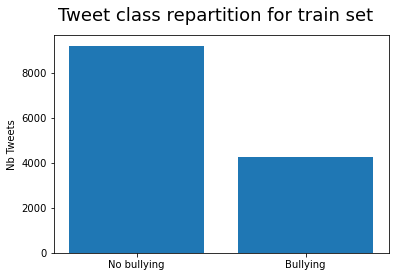

In [18]:
fig, ax = plt.subplots()
ax.bar(["No bullying", "Bullying"], [len_no_bullying_train, len_bullying_train])
ax.set_ylabel("Nb Tweets")
fig.suptitle("Tweet class repartition for train set", fontsize=18)

Text(0.5, 0.98, 'Tweet class repartition for test set')

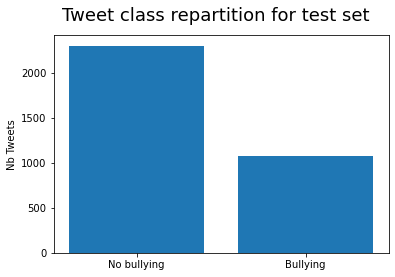

In [19]:
fig, ax = plt.subplots()
ax.bar(["No bullying", "Bullying"], [len_no_bullying_test, len_bullying_test])
ax.set_ylabel("Nb Tweets")
fig.suptitle("Tweet class repartition for test set", fontsize=18)

## Split dataset tweets/labels

In [43]:
X_train, y_train = df_train.iloc[:, :-2], df_train.iloc[:, 2]
X_test, y_test = df_test.iloc[:, :-2], df_test.iloc[:, 2]

## Plot metrics

In [46]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Dataset preparation

In [47]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [60]:
train_set = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
test_set = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

train_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [61]:
for feat, label in train_dataset.take(1):
  print('Features: {}, Target: {}'.format(feat, label))

Features: [[b"b) that girls weren't supposed to do it, I would have been on that shit"]
 [b'Saddest Leo ever. One of his treats rolled beneath the table and he fell asleep staring at it. http://t.co/7CLFmgLSe2']
 [b"RT @tassiedad:I'm sure the pot that it was cooked in was hot! #MKR #killerblondes\n RT:@.vid.http://t.co/aBArMeZh86"]
 [b'@harmlesstree2 Again you are an idiot. The Muslims were thugs. They quickly figured out that if they forced everyone to convert there..']
 [b"@ktonieskacze @Femitheist Agreed. Thoughtful. Every once in a while an old tweet of mine lumping her Poe in w Gearheart is RT'ed. I cringe."]
 [b'Arrgh my hearties we get to see Captain Salty farm more salt Thursday and her trusty gimp I mean first mate do nothing at all #mkr']
 [b'Thank god for consulting to fuel my blackmilk addiction.']
 [b"RT @NotFaulty: Mark Kern is the dictionary definition of 'Willfully Dense' http://t.co/Yfu94K6iD3"]
 [b'I think the worst is when women shame other women for not shaving. You

## Training

In [62]:
VOCAB_SIZE = 50000

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [64]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'mkr', 'a', 'i', 'and', 'is', 'of', 'rt',
       'you', 'that', 'in', 'not', 'are', 'it', 'but', 'for', 'they'],
      dtype='<U78')

In [66]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [67]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [69]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
211/211 [==============================] - 8s 36ms/step - loss: 0.2520 - accuracy: 0.8995 - val_loss: 0.1861 - val_accuracy: 0.9286
Epoch 2/10
211/211 [==============================] - 8s 36ms/step - loss: 0.1789 - accuracy: 0.9334 - val_loss: 0.1285 - val_accuracy: 0.9479
Epoch 3/10
211/211 [==============================] - 8s 36ms/step - loss: 0.1314 - accuracy: 0.9553 - val_loss: 0.0950 - val_accuracy: 0.9724
Epoch 4/10
211/211 [==============================] - 8s 36ms/step - loss: 0.1002 - accuracy: 0.9682 - val_loss: 0.0685 - val_accuracy: 0.9792
Epoch 5/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0739 - accuracy: 0.9782 - val_loss: 0.0634 - val_accuracy: 0.9802
Epoch 6/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0566 - accuracy: 0.9834 - val_loss: 0.0459 - val_accuracy: 0.9880
Epoch 7/10
211/211 [==============================] - 8s 37ms/step - loss: 0.0442 - accuracy: 0.9869 - val_loss: 0.0373 - val_accuracy: 0.9891

In [70]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


211/211 [==============================] - 1s 7ms/step - loss: 0.0208 - accuracy: 0.9951
Test Loss: 0.020754653960466385
Test Accuracy: 0.995103120803833


(0.0, 0.26378908520564437)

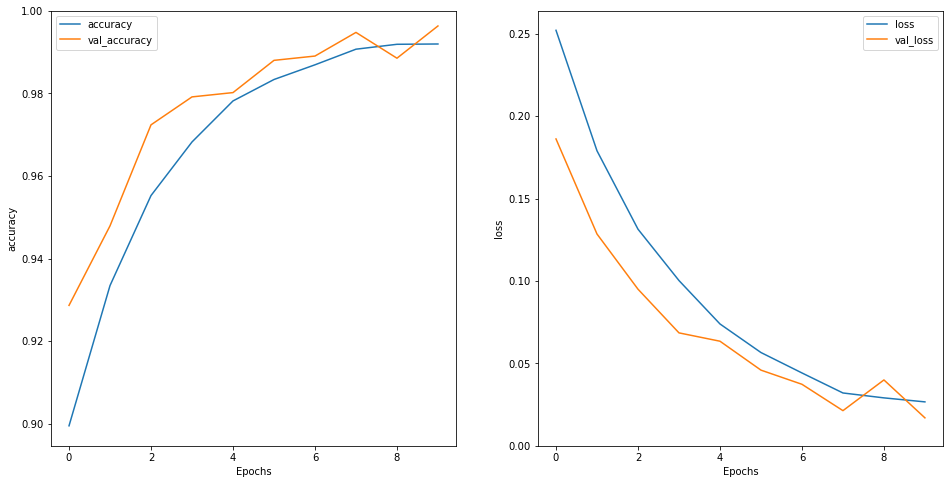

In [71]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [86]:
predictions2 = np.where(model.predict(X_test) > 0.5, 1, 0)

In [90]:
from sklearn.metrics import classification_report, confusion_matrix

In [91]:
print(confusion_matrix(y_test,predictions2))

[[1912  388]
 [ 240  830]]


In [88]:
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86      2300
         1.0       0.68      0.78      0.73      1070

    accuracy                           0.81      3370
   macro avg       0.78      0.80      0.79      3370
weighted avg       0.82      0.81      0.82      3370

